In [1]:
from lib.utilities import *
%matplotlib inline

In [2]:
############### User Configuration ###############
##################################################

datadir = "." # All ZDA files in this directory + subdirectories will be loaded
selected_filename = "07-09-21_04_01" # focus for subsequent analysis
force_reload = True # Set to True if data in zda_targets dir has changed

./zda_targets/07-09-21_02_01.zda
./zda_targets/07-09-21_04_01.zda
Number of files loaded: 2


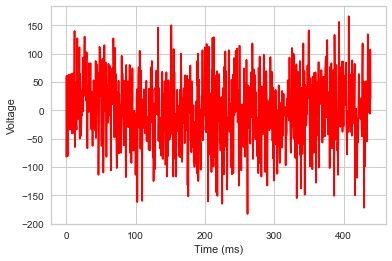

In [3]:
############## Driver script: begin ##############
##################################################

# Load data
if force_reload or (data_loader is None) or data_loader.get_n_files_loaded() < 1: 
    data_loader = DataLoader()
    data_loader.load_all_zda(data_dir=datadir + "/zda_targets")
    print('Number of files loaded:', data_loader.get_n_files_loaded())


# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# Clip to the time range 20 - 90 ms (get rid of the camera "foot", look at prestim only)
if selected_data is not None:
    
    selected_data.clip_data(t_range=[120,-1])
    raw_data, meta, rli = selected_data.get_data(trial=0), selected_data.get_meta(), selected_data.get_rli()

    # Need to subtract off the low-frequency voltage drift. First-order correction
    tr = Tracer()
    tr.correct_background(meta, raw_data, trial_dim=False)

    #full trace
    tr.plot_trace(raw_data[:,:,:], 
               40, 
               40, 
               meta['interval_between_samples'])
else:
    print("Filename containing '" + selected_filename + "' not found. \n\tCheck zda_targets folder and/or set force_reload=True")

In [12]:
# Frequency Decompositions

freq_analzyer = FreqAnalyzer()

x_fft = freq_analzyer.compute_fft_binning(meta)
y_fft_avg = None
n = raw_data.shape[0] * raw_data.shape[1]

for x in range(raw_data.shape[0]):
    for y in range(raw_data.shape[1]):
            
            y_fft = freq_analzyer.decompose_trace_frequencies(meta, 
                                                raw_data[x,y,:],
                                                x_fft=x_fft,
                                                lower_freq=0,
                                                upper_freq=50,
                                                y_max=2000,
                                                plot=False)
            if y_fft_avg is None:
                y_fft_avg = y_fft / n
            else:
                y_fft_avg += y_fft / n

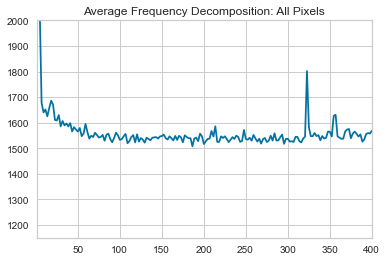

<Figure size 432x288 with 0 Axes>

In [14]:
# Mean frequency decomposition (averaged by frequency over all pixels)
plt.plot(x_fft, 
         np.abs(y_fft_avg))
plt.xlim([1, 400])
plt.ylim([1150,2000])
plt.title("Average Frequency Decomposition: All Pixels")
plt.show()
plt.savefig(selected_filename + "_avg_freq.jpg")

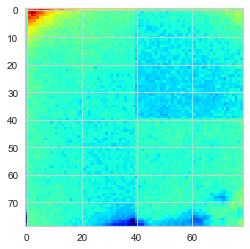

max SNR: 0.01799230444575025 
min SNR: 0.001684895339094932


In [6]:
# Average only for high-SNR and/or ROIs

trial = selected_data.get_data(trial=0)
asnr = AnalyzerSNR(trial)

snr = asnr.get_snr(plot=True)

print("max SNR:", np.max(snr), 
      "\nmin SNR:", np.min(snr))

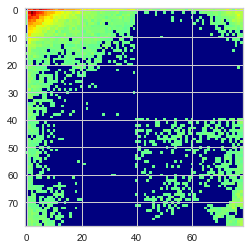

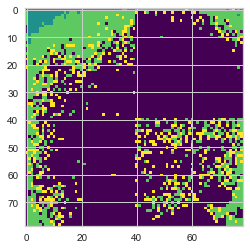

array([[4, 2, 2, ..., 2, 3, 2],
       [3, 2, 2, ..., 3, 3, 3],
       [3, 2, 2, ..., 3, 2, 3],
       ...,
       [1, 3, 3, ..., 3, 3, 3],
       [1, 3, 3, ..., 4, 3, 3],
       [1, 3, 3, ..., 3, 3, 3]])

In [7]:
# cluster by SNR and display
asnr.cluster_on_snr(plot=True)

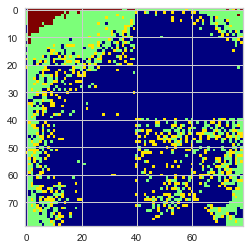

In [8]:
 # k=0 is highest SNR cluster (indices returned)
avg_snr_by_cluster = asnr.get_average_snr_by_cluster()
highest_snr_cluster = asnr.get_kth_cluster(0, plot=True)

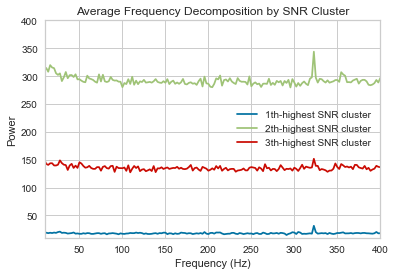

<Figure size 432x288 with 0 Axes>

In [16]:
# Frequency Decompositions for 3 highest-SNR clusters
for k in range(3):
    snr_cluster = asnr.get_kth_cluster(k, plot=False)
    if(snr_cluster.shape[1] < 1): # cluster is empty
        continue 
    freq_analzyer = FreqAnalyzer()

    x_fft = freq_analzyer.compute_fft_binning(meta)
    y_fft_avg = None
    n = raw_data.shape[0] * raw_data.shape[1]
    for i in range(snr_cluster.shape[1]):
        x = snr_cluster[0][i]
        y = snr_cluster[1][i]

        y_fft = freq_analzyer.decompose_trace_frequencies(meta, 
                                            raw_data[x,y,:],
                                            x_fft=x_fft,
                                            lower_freq=0,
                                            upper_freq=50,
                                            y_max=2000,
                                            plot=False)
        if y_fft_avg is None:
            y_fft_avg = y_fft / n
        else:
            y_fft_avg += y_fft / n

    # Mean frequency decomposition (averaged by frequency over all pixels)
    plt.plot(x_fft, 
             np.abs(y_fft_avg),
             label=str(k+1) +"th-highest SNR cluster")
plt.xlim([10, 400])
plt.ylim([10,400])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.title("Average Frequency Decomposition by SNR Cluster")
plt.show()
plt.savefig(selected_filename + "_all_freq.jpg")